<a href="https://colab.research.google.com/github/vahidzad/vahidzad-When-Computer-vision-meets-Electromagnetics/blob/main/Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_addons as tfa
tf.test.gpu_device_name()
!nvidia-smi 

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/My Drive/Colab Notebooks/Vision/'

Abs-1d.txt  Cross_sections   Features-3d.txt  Runtime-2d.txt
Abs-2d.txt  Features-1d.txt  Final_Models     Runtime-3d.txt
Abs-3d.txt  Features-2d.txt  Runtime-1d.txt   Wavelength.txt


In [ ]:
Index_address = '/content/drive/My Drive/Colab Notebooks/Vision/Raw_indecies/'
images_dir = '/content/drive/My Drive/Colab Notebooks/Vision/Cross_sections'
Result1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-1d.txt'
Result2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-2d.txt'
Result3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-3d.txt'

In [ ]:
# Saving Cross section images in the drive
'''
for i in range (2386,2427):
  Index_address_temp = Index_address + str(i) + ".txt"
  data = pd.read_csv(Index_address_temp, sep='\t', header = None,engine='python')
  ax = sns.heatmap(data, cmap="Paired", xticklabels=False, yticklabels=False,cbar = False , vmin=0, vmax=6)
  figure = ax.get_figure()
  plt.savefig(f"{images_dir}/%d.jpg"%(i))
  del data
'''

'\nfor i in range (2386,2427):\n  Index_address_temp = Index_address + str(i) + ".txt"\n  data = pd.read_csv(Index_address_temp, sep=\'\t\', header = None,engine=\'python\')\n  ax = sns.heatmap(data, cmap="Paired", xticklabels=False, yticklabels=False,cbar = False , vmin=0, vmax=6)\n  figure = ax.get_figure()\n  plt.savefig(f"{images_dir}/%d.jpg"%(i))\n  del data\n'

In [ ]:
#Classifier Results
Result1D = pd.read_csv(Result1D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Result2D_adress, sep='\t', header = None,engine='python')
Result3D = pd.read_csv(Result3D_adress, sep='\t', header = None,engine='python')
Results = pd.concat([Result1D, Result2D,Result3D])
Results = Results.drop([0],axis=1)  # get rid of the number of layers for now
Results_classification = Results.drop([8,9,10],axis=1)

In [ ]:
Results_classification.head()

,1,2,3,4,5,6,7
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0


In [ ]:
for i in range (7):
  print('the number of instnaces in class ' + str(i+1) + ' is: ', Results_classification[i+1].value_counts()  )

the number of instnaces in class 1 is:  1    1213
0    1213
Name: 1, dtype: int64
the number of instnaces in class 2 is:  1    1213
0    1213
Name: 2, dtype: int64
the number of instnaces in class 3 is:  0    1684
1     742
Name: 3, dtype: int64
the number of instnaces in class 4 is:  0    1684
1     742
Name: 4, dtype: int64
the number of instnaces in class 5 is:  0    1684
1     742
Name: 5, dtype: int64
the number of instnaces in class 6 is:  0    1676
1     750
Name: 6, dtype: int64
the number of instnaces in class 7 is:  0    1676
1     750
Name: 7, dtype: int64


In [ ]:
Results_classification.shape

(2426, 7)

In [ ]:
#Loading the images (Features) for Regression
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

Features = []

for i in tqdm(range(Results.shape[0])):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  Features.append(img)
Features = np.array(Features)

100%|██████████| 2426/2426 [00:07<00:00, 314.44it/s]


In [ ]:
Features.shape

(2426, 72, 108, 3)

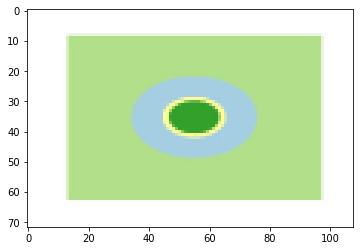

In [ ]:
plt.imshow(Features[1380])

In [ ]:
#splitting the data to train and test for Regressor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Features, Results_classification, random_state = 0, test_size = 0.2)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from tensorflow_addons.metrics import HammingLoss
LaekyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)



#Classifier Model
model = Sequential()
model.add(Conv2D(32, (3,3), activation=LaekyRelu, input_shape = X_train[0].shape))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

'''
model.add(Conv2D(64, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

'''

model.add(Flatten())

model.add(Dense(32, activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(7, activation='sigmoid'))

NameError: ignored

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 70, 106, 32)       896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 35, 53, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 35, 53, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 33, 51, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 25, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 16, 25, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 23, 128)      

In [ ]:
tf.keras.backend.clear_session()     
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['binary_accuracy']) #metrics=['accuracy']  loss='binary_crossentropy'  #metrics=['binary_accuracy'] metrics=[HammingLoss(threshold=0.5, mode='multilabel')]                                                                                      
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
history = model.fit(X_train, y_train, validation_split=0.2,batch_size=128, epochs=500,callbacks=callback)


Epoch 1/500
13/13 [==============================] - 1s 66ms/step - loss: 0.6797 - binary_accuracy: 0.5732 - val_loss: 0.6687 - val_binary_accuracy: 0.6314
Epoch 2/500
13/13 [==============================] - 1s 45ms/step - loss: 0.6535 - binary_accuracy: 0.6238 - val_loss: 0.6496 - val_binary_accuracy: 0.6480
Epoch 3/500
13/13 [==============================] - 1s 44ms/step - loss: 0.6453 - binary_accuracy: 0.6377 - val_loss: 0.6467 - val_binary_accuracy: 0.6826
Epoch 4/500
13/13 [==============================] - 1s 44ms/step - loss: 0.6380 - binary_accuracy: 0.6464 - val_loss: 0.6409 - val_binary_accuracy: 0.6668
Epoch 5/500
13/13 [==============================] - 1s 45ms/step - loss: 0.6266 - binary_accuracy: 0.6613 - val_loss: 0.6250 - val_binary_accuracy: 0.7106
Epoch 6/500
13/13 [==============================] - 1s 44ms/step - loss: 0.6105 - binary_accuracy: 0.6783 - val_loss: 0.6033 - val_binary_accuracy: 0.7158
Epoch 7/500
13/13 [==============================] - 1s 44ms/ste

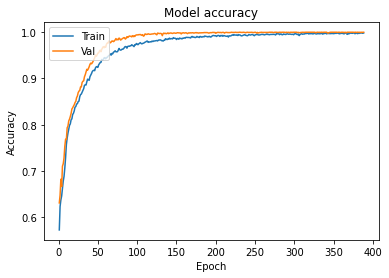

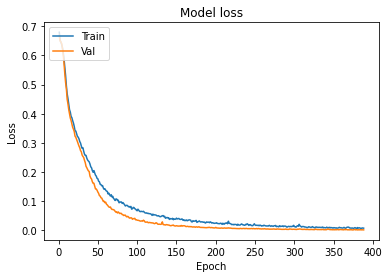

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history["binary_accuracy"])
  plt.plot(epoch_range, history.history["val_binary_accuracy"])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history, len(history.history['loss']))

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame(history.history['val_loss'])

In [ ]:
def label_maker (L):
  L[L >= 0.5] = 1
  L[L < 0.5] = 0
  return L

In [ ]:
i = 120
print(label_maker(model.predict(X_test[i].reshape(1,72,108,3))))
print(y_test.iloc[i,:])

[[1. 0. 0. 0. 1. 0. 1.]]
1    1
2    0
3    0
4    0
5    1
6    0
7    1
Name: 684, dtype: int64


In [ ]:
#saving the model
#model.save('Vision_classifier_small.h5')

In [ ]:
'''
model = Sequential()
model.add(Conv2D(32, (3,3), activation=LaekyRelu, input_shape = X_train[0].shape))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(128, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Conv2D(64, (3,3), activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(32, activation=LaekyRelu))
#model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(Dense(7, activation='sigmoid'))

'''

"\nmodel = Sequential()\nmodel.add(Conv2D(16, (3,3), activation=LaekyRelu, input_shape = X_train[0].shape))\n#model.add(BatchNormalization())\nmodel.add(MaxPool2D(2,2))\nmodel.add(Dropout(0.3))\n\nmodel.add(Conv2D(32, (3,3), activation=LaekyRelu))\n#model.add(BatchNormalization())\nmodel.add(MaxPool2D(2,2))\nmodel.add(Dropout(0.2))\n\nmodel.add(Conv2D(32, (3,3), activation=LaekyRelu))\n#model.add(BatchNormalization())\nmodel.add(MaxPool2D(2,2))\nmodel.add(Dropout(0.2))\n\n\nmodel.add(Flatten())\n\nmodel.add(Dense(32, activation=LaekyRelu))\n#model.add(BatchNormalization())\nmodel.add(Dropout(0.5))\n\n\nmodel.add(Dense(7, activation='sigmoid'))\n\n\n"

In [ ]:
#Loading the images (Features) for Regression
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

Features2 = []

for i in tqdm(range(Results.shape[0])):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  Features2.append(img)
Features2 = np.array(Features2)

100%|██████████| 2426/2426 [00:08<00:00, 291.55it/s]


In [ ]:
#Regressor Results
Result1D = pd.read_csv(Result1D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Result2D_adress, sep='\t', header = None,engine='python')
Result3D = pd.read_csv(Result3D_adress, sep='\t', header = None,engine='python')
Results_Regressor = pd.concat([Result1D, Result2D,Result3D])
Results_Regressor = Results_Regressor.drop([0,1,2,3,4,5,6,7],axis=1)  # get rid of the number of layers and Classification parameters
Results_Regressor = Results_Regressor*1E+9  #converting nm to a more sensible values

In [ ]:
Results_Regressor.tail()

,8,9,10
1495,25.0,25.0,5.0
1496,25.0,25.0,10.0
1497,25.0,25.0,15.0
1498,25.0,25.0,20.0
1499,25.0,25.0,25.0


In [ ]:
#splitting the data to train and test for Regressor
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(Features2, Results_Regressor, random_state = 0, test_size = 0.2)

In [ ]:
X_train2.shape

(1940, 72, 108, 3)

In [ ]:
y_train2.shape

(1940, 3)

In [ ]:
'''
#Regressor Model
model2 = Sequential()
model2.add(Conv2D(64, (3,3), activation=tanh, input_shape = X_train2[0].shape))
#model2.add(BatchNormalization())   #momentum=0.8
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3,3), activation=tanh))
#model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, (3,3), activation=tanh))
#model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.2))


model2.add(Flatten())

model2.add(Dense(1024, activation=tanh))
#model2.add(BatchNormalization())
model2.add(Dropout(0.05))


model2.add(Dense(3, activation='linear'))
'''

"\n#Regressor Model\nmodel2 = Sequential()\nmodel2.add(Conv2D(64, (3,3), activation=tanh, input_shape = X_train2[0].shape))\n#model2.add(BatchNormalization())   #momentum=0.8\nmodel2.add(MaxPool2D(2,2))\nmodel2.add(Dropout(0.2))\n\nmodel2.add(Conv2D(64, (3,3), activation=tanh))\n#model2.add(BatchNormalization())\nmodel2.add(MaxPool2D(2,2))\nmodel2.add(Dropout(0.2))\n\nmodel2.add(Conv2D(64, (3,3), activation=tanh))\n#model2.add(BatchNormalization())\nmodel2.add(MaxPool2D(2,2))\nmodel2.add(Dropout(0.2))\n\n\nmodel2.add(Flatten())\n\nmodel2.add(Dense(1024, activation=tanh))\n#model2.add(BatchNormalization())\nmodel2.add(Dropout(0.05))\n\n\nmodel2.add(Dense(3, activation='linear'))\n"

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from tensorflow_addons.metrics import HammingLoss
LaekyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)
tanh = tf.keras.activations.tanh
relu = tf.keras.activations.relu

#Regressor Model
model2 = Sequential()
model2.add(Conv2D(64, (3,3), activation=tanh, input_shape = X_train2[0].shape))
#model2.add(BatchNormalization())   #momentum=0.8
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.1))

model2.add(Conv2D(64, (3,3), activation=tanh))
#model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.1))

model2.add(Conv2D(64, (3,3), activation=tanh))
#model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.1))


'''
model2.add(Conv2D(64, (3,3), activation=relu))
model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.2))

'''
'''
model2.add(Conv2D(16, (3,3), activation=LaekyRelu))
#model2.add(BatchNormalization())
model2.add(MaxPool2D(2,2))
model2.add(Dropout(0.2))
'''

model2.add(Flatten())

model2.add(Dense(1024, activation=tanh))
#model2.add(BatchNormalization())
model2.add(Dropout(0.05))


model2.add(Dense(3, activation='linear'))

In [ ]:
tf.keras.backend.clear_session()     
model2.compile(loss='mae', optimizer=Adam(lr=0.0001), metrics=['accuracy']) #metrics=['accuracy']  loss='binary_crossentropy'  #metrics=['binary_accuracy'] metrics=[HammingLoss(threshold=0.5, mode='multilabel')]                                                                                      
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
history2 = model2.fit(X_train2, y_train2, validation_split=0.2,batch_size=32, epochs=750,callbacks=callback)

Epoch 1/750
49/49 [==============================] - 1s 19ms/step - loss: 9.0198 - accuracy: 0.4929 - val_loss: 8.6761 - val_accuracy: 0.5052
Epoch 2/750
49/49 [==============================] - 1s 16ms/step - loss: 8.4169 - accuracy: 0.5309 - val_loss: 8.5430 - val_accuracy: 0.5619
Epoch 3/750
49/49 [==============================] - 1s 16ms/step - loss: 7.8260 - accuracy: 0.5889 - val_loss: 7.9559 - val_accuracy: 0.5206
Epoch 4/750
49/49 [==============================] - 1s 16ms/step - loss: 6.4525 - accuracy: 0.6372 - val_loss: 9.7912 - val_accuracy: 0.5490
Epoch 5/750
49/49 [==============================] - 1s 16ms/step - loss: 5.4868 - accuracy: 0.6720 - val_loss: 8.2137 - val_accuracy: 0.6649
Epoch 6/750
49/49 [==============================] - 1s 16ms/step - loss: 4.7312 - accuracy: 0.6901 - val_loss: 9.6042 - val_accuracy: 0.6881
Epoch 7/750
49/49 [==============================] - 1s 16ms/step - loss: 4.1890 - accuracy: 0.7236 - val_loss: 8.5495 - val_accuracy: 0.6392
Epoch 

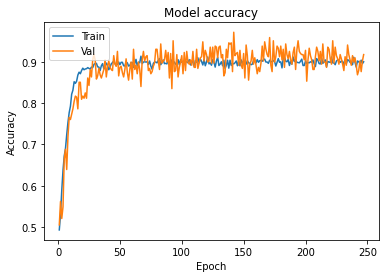

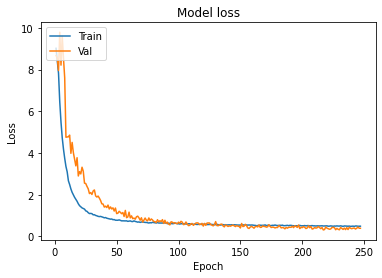

In [ ]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history2.history["accuracy"])
  plt.plot(epoch_range, history2.history["val_accuracy"])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history2.history['loss'])
  plt.plot(epoch_range, history2.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history2, len(history2.history['loss']))

In [ ]:
i = 12
print(model2.predict(X_test2[i].reshape(1,72, 108,3)))   #72, 108
print(y_test2.iloc[i,:])

[[25.051249 20.3537   15.041001]]
8     25.0
9     20.0
10    15.0
Name: 992, dtype: float64


In [ ]:
#saving the model
#model2.save('Vision_regressor_small.h5')

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame(history2.history['loss'])

In [ ]:
#loading the saved model
Regressor =  tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Vision_regressor_small.h5')


In [ ]:
#Classifier + Regressor Results
Result1D = pd.read_csv(Result1D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Result2D_adress, sep='\t', header = None,engine='python')
Result3D = pd.read_csv(Result3D_adress, sep='\t', header = None,engine='python')
Results = pd.concat([Result1D, Result2D,Result3D])
Results_classification_regression = Results.drop([0],axis=1)  # get rid of the number of layers for now
Results_classification_regression[[8,9,10]] = Results_classification_regression[[8,9,10]]*1E9


In [ ]:
Results_classification_regression.tail()

,1,2,3,4,5,6,7,8,9,10
1495,0,1,0,0,1,0,1,25.0,25.0,5.0
1496,0,1,0,0,1,0,1,25.0,25.0,10.0
1497,0,1,0,0,1,0,1,25.0,25.0,15.0
1498,0,1,0,0,1,0,1,25.0,25.0,20.0
1499,0,1,0,0,1,0,1,25.0,25.0,25.0


In [ ]:
#Loading the images (Features) for Classifier + Regressor 
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

Features3 = []

for i in tqdm(range(Results.shape[0])):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  Features3.append(img)
Features3 = np.array(Features3)

100%|██████████| 2426/2426 [00:09<00:00, 265.65it/s]


In [ ]:
#splitting the data to train and test for Classifier + Regressor 
from sklearn.model_selection import train_test_split
X_train3, X_test3, y_train3, y_test3 = train_test_split(Features3, Results_classification_regression, random_state = 0, test_size = 0.2)
y_train31 =  y_train3.drop([8,9,10],axis=1).values   #for classification
y_test31 =  y_test3.drop([8,9,10],axis=1).values   #for classification
y_train32 =  y_train3.drop([1,2,3,4,5,6,7],axis=1).values   #for Regression
y_test32 =  y_test3.drop([1,2,3,4,5,6,7],axis=1).values   #for Regression

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from keras.layers import LeakyReLU
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
LaekyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)
tanh = tf.keras.activations.tanh
relu = tf.keras.activations.relu


#### 
input = Input(shape=(X_train3[0].shape))              
layer1 = Conv2D(64,(3,3), activation=relu)(input)
#BatchNormalization1 = BatchNormalization()(layer1)
MaxPooling1 = MaxPooling2D((2,2))(layer1)


layer2 = Conv2D(64,(3,3), activation=relu)(MaxPooling1)
#BatchNormalization2 = BatchNormalization()(layer2)
MaxPooling2 = MaxPooling2D((2,2))(layer2)


#Classification

CLF1 = Conv2D(32,(3,3), activation=relu)(MaxPooling2)
#BatchNormalization_CLF1 = BatchNormalization()(CLF1)
MaxPooling_CLF1 = MaxPooling2D((2,2))(CLF1)
drop_CLF1 = Dropout(0.20)(MaxPooling_CLF1)

Flatten_CLF = Flatten()(drop_CLF1)

CLF = Dense(7, activation='sigmoid', name='classification')(Flatten_CLF)


#Regression
REG1 = Conv2D(64,(3,3), activation=relu)(MaxPooling2)
#BatchNormalization_REG1 = BatchNormalization()(REG1)
MaxPooling_REG1 = MaxPooling2D((2,2))(REG1)

REG2 = Conv2D(64,(3,3), activation=relu)(MaxPooling_REG1)
#BatchNormalization_REG1 = BatchNormalization()(REG1)
MaxPooling_REG2 = MaxPooling2D((2,2))(REG2)

'''
REG2 = Conv2D(64,(3,3), activation='tanh')(drop_REG1)
MaxPooling_REG2 = MaxPooling2D((2,2))(REG2)
drop_REG2 = Dropout(0.20)(MaxPooling_REG2)

'''
Flatten_REG = Flatten()(MaxPooling_REG2)

REG = Dense(3, activation='linear', name='regression')(Flatten_REG)

model3 = Model(input, outputs=[CLF, REG])

model3.compile(loss={'classification': 'binary_crossentropy', 
                    'regression': 'mae'},
              loss_weights={'classification': 0.1,
                            'regression': 0.9},
              optimizer=Adam(learning_rate=0.001),  #learning_rate=0.0001
              metrics={'classification': 'binary_accuracy', 'regression': 'mae'})

In [ ]:
from keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()     
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto',baseline=None, restore_best_weights=False)

history3 = model3.fit(X_train3, [y_train31,y_train32],epochs=1500,validation_split=0.2,callbacks=callback,verbose=1)

Epoch 1/1500
49/49 [==============================] - 1s 20ms/step - loss: 8.7521 - classification_loss: 0.6466 - regression_loss: 9.6527 - classification_binary_accuracy: 0.6449 - regression_mae: 9.6527 - val_loss: 7.7234 - val_classification_loss: 0.6362 - val_regression_loss: 8.5109 - val_classification_binary_accuracy: 0.6322 - val_regression_mae: 8.5109
Epoch 2/1500
49/49 [==============================] - 1s 14ms/step - loss: 7.4774 - classification_loss: 0.5960 - regression_loss: 8.2420 - classification_binary_accuracy: 0.6883 - regression_mae: 8.2420 - val_loss: 7.1938 - val_classification_loss: 0.5440 - val_regression_loss: 7.9327 - val_classification_binary_accuracy: 0.7080 - val_regression_mae: 7.9327
Epoch 3/1500
49/49 [==============================] - 1s 14ms/step - loss: 6.7037 - classification_loss: 0.4955 - regression_loss: 7.3935 - classification_binary_accuracy: 0.7394 - regression_mae: 7.3935 - val_loss: 6.1720 - val_classification_loss: 0.4557 - val_regression_loss

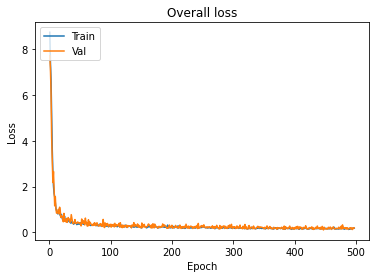

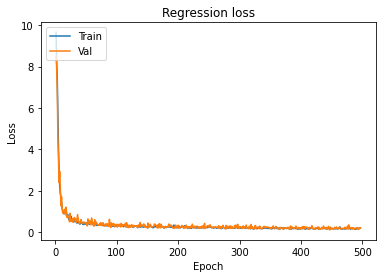

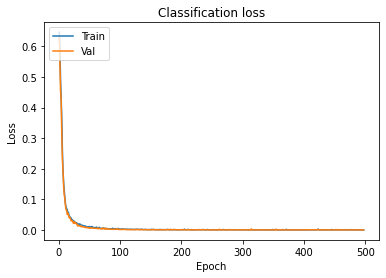

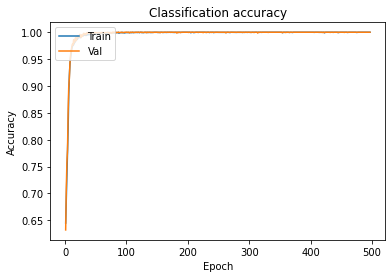

In [ ]:
def plot_learningCurve(history, epoch):
  epoch_range = range(1, epoch+1)

  # Plot training & validation loss values
  plt.plot(epoch_range, history3.history['loss'])
  plt.plot(epoch_range, history3.history['val_loss'])
  plt.title('Overall loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history3.history['regression_loss'])
  plt.plot(epoch_range, history3.history['val_regression_loss'])
  plt.title('Regression loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history3.history['classification_loss'])
  plt.plot(epoch_range, history3.history['val_classification_loss'])
  plt.title('Classification loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()


  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history3.history["classification_binary_accuracy"])
  plt.plot(epoch_range, history3.history["val_classification_binary_accuracy"])
  plt.title('Classification accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()


plot_learningCurve(history3, len(history3.history['loss']))

In [ ]:
#saving the model
#model3.save('Vision_classifier_regressor_small.h5')

In [ ]:
i = 12
print(model3.predict(X_test3[i].reshape(1,72, 108,3)))   #72, 108
print(y_test31[i,:])
print(y_test32[i,:])

[array([[5.4678789e-11, 1.0000000e+00, 1.0000000e+00, 1.2201418e-30,
        7.8009577e-27, 1.5450847e-13, 1.0000000e+00]], dtype=float32), array([[25.269194, 20.053074, 15.043696]], dtype=float32)]
[0 1 1 0 0 0 1]
[25. 20. 15.]


In [ ]:
#pd.set_option('display.max_rows', None)
#pd.DataFrame(history3.history['val_classification_loss'])

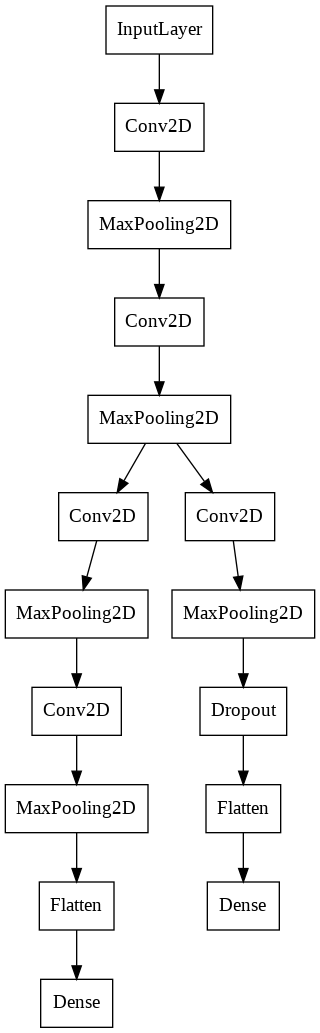

In [ ]:
#loading the saved model and visualizing it
Regressor_classifier =  tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Vision_classifier_regressor_small.h5')
tf.keras.utils.plot_model(Regressor_classifier, show_shapes=False,show_layer_names=False, rankdir='TB')


In [ ]:
!pip install visualkeras

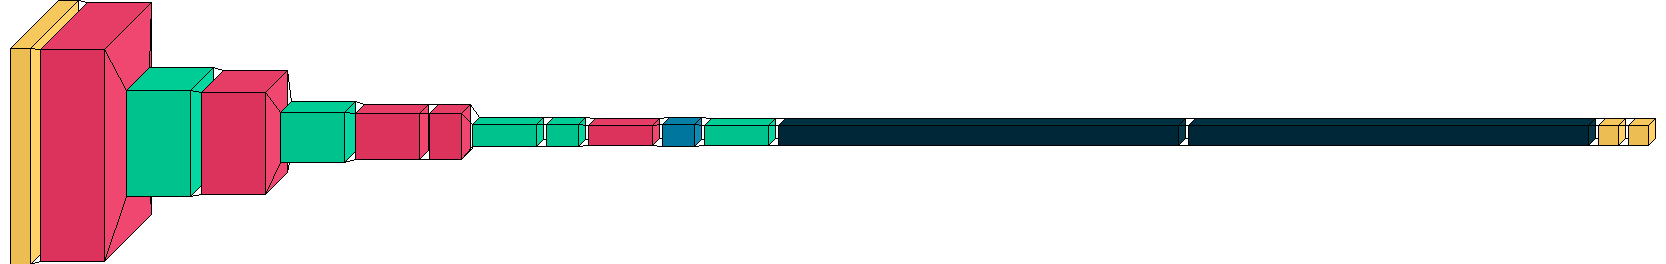

In [ ]:
import visualkeras
visualkeras.layered_view(Regressor_classifier,scale_xy=2, scale_z=1)

In [ ]:
Regressor_classifier.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 108, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 70, 106, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 35, 53, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 33, 51, 64)   36928       max_pooling2d[0][0]              
_______________________________________________________________________________________

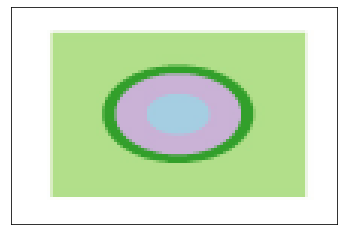

In [ ]:
inter_model1 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('conv2d').output)
inter_model2 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('max_pooling2d').output)

inter_model3 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('conv2d_1').output)
inter_model4 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('max_pooling2d_1').output)

inter_model5 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('conv2d_2').output)  #classification specific 
inter_model6 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('max_pooling2d_2').output)

inter_model7 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('conv2d_3').output) #regression specific
inter_model8 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('max_pooling2d_3').output)

inter_model9 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('conv2d_4').output) #regression specific
inter_model10 = tf.keras.Model(inputs=Regressor_classifier.input,outputs=Regressor_classifier.get_layer('max_pooling2d_4').output)



i =2
output1 = inter_model1.predict(X_test3[i].reshape(1,72, 108,3)).reshape(70, 106, 64)
output2 = inter_model2.predict(X_test3[i].reshape(1,72, 108,3)).reshape(35, 53, 64)

output3 = inter_model3.predict(X_test3[i].reshape(1,72, 108,3)).reshape(33, 51, 64)
output4 = inter_model4.predict(X_test3[i].reshape(1,72, 108,3)).reshape(16, 25, 64)

output5 = inter_model5.predict(X_test3[i].reshape(1,72, 108,3)).reshape(14, 23, 32)
output6 = inter_model6.predict(X_test3[i].reshape(1,72, 108,3)).reshape(7, 11, 32)

output7 = inter_model7.predict(X_test3[i].reshape(1,72, 108,3)).reshape(14, 23, 64)
output8 = inter_model8.predict(X_test3[i].reshape(1,72, 108,3)).reshape(7, 11, 64)

output9 = inter_model9.predict(X_test3[i].reshape(1,72, 108,3)).reshape(5, 9, 64)
output10 = inter_model10.predict(X_test3[i].reshape(1,72, 108,3)).reshape(2, 4, 64)

plt.imshow(X_test3[i])
plt.xticks([])
plt.yticks([])
plt.savefig('sample.png', dpi=1000 , bbox_inches='tight')

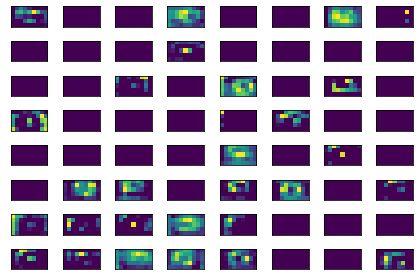

In [ ]:
for j in range(1, 65):
  plt.subplot(8, 8, j)
  opt = output9
  m=int(opt.shape[2]/4)
  plt.imshow(opt[:, :,j-1])
  plt.xticks([])
  plt.yticks([])
  plt.tight_layout()
  


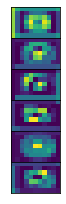

In [ ]:
for i,j in enumerate([3,9,10,28,33,59]):  #Layer1,2 = [1,2,7,35,51,60]  Layer3,4 = [3,12,26,48,57,63]  Layer5,6 = [13,14,15,26,27,32]  Layer7,8 =[3,9,10,28,33,59] Layer9,10 =[1,4,25,46,61,64]
  plt.subplot(7, 1, i+1)
  opt = output8
  plt.imshow(opt[:, :,j-1])
  plt.xticks([])
  plt.yticks([])
  plt.subplots_adjust(hspace=0.0, wspace=0.0)
#plt.savefig('layer8.png', dpi=1000 , bbox_inches='tight')

In [ ]:
Wavelength_adress='/content/drive/My Drive/Colab Notebooks/Vision/Wavelength.txt'
Abs_Result3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Abs-3d.txt'
Abs_Result2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Abs-2d.txt'
Abs_Result1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Abs-1d.txt'
Feature1D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-1d.txt'
Feature2D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-2d.txt'
Feature3D_adress = '/content/drive/My Drive/Colab Notebooks/Vision/Features-3d.txt'

In [ ]:
#Features for decoder network
Feature1D = pd.read_csv(Feature1D_adress, sep='\t', header = None,engine='python')
Feature2D = pd.read_csv(Feature2D_adress, sep='\t', header = None,engine='python')
Feature3D = pd.read_csv(Feature3D_adress, sep='\t', header = None,engine='python')
Features4 = pd.concat([Feature1D, Feature2D,Feature3D])
Features4 = Features4.drop([0],axis=1)  # get rid of the number of layers for now

Features4[8] = Features4[8].apply(lambda x: x*1E+9)
Features4[9] = Features4[9].apply(lambda x: x*1E+9)
Features4[10] = Features4[10].apply(lambda x: x*1E+9)

In [ ]:
#Features for decoder network
Wavelength = pd.read_csv(Wavelength_adress, sep="\t", header=None)
Result3D = pd.read_csv(Abs_Result3D_adress, sep='\t', header = None,engine='python')
Result2D = pd.read_csv(Abs_Result2D_adress, sep='\t', header = None,engine='python')
Result1D = pd.read_csv(Abs_Result1D_adress, sep='\t', header = None,engine='python')
Results4 = pd.concat([Result1D,Result2D,Result3D],axis=1,ignore_index=True)*1E7

In [ ]:
Features4.shape

(2426, 10)

In [ ]:
Features4.tail()

,1,2,3,4,5,6,7,8,9,10
1495,0,1,0,0,1,0,1,25.0,25.0,5.0
1496,0,1,0,0,1,0,1,25.0,25.0,10.0
1497,0,1,0,0,1,0,1,25.0,25.0,15.0
1498,0,1,0,0,1,0,1,25.0,25.0,20.0
1499,0,1,0,0,1,0,1,25.0,25.0,25.0


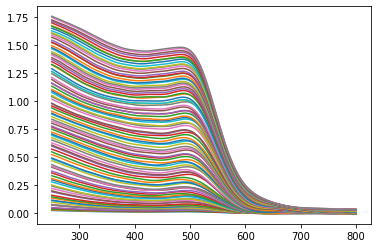

In [ ]:
for i in range(1,99):
  x = Results4[i]
  plt.plot(Wavelength,x)

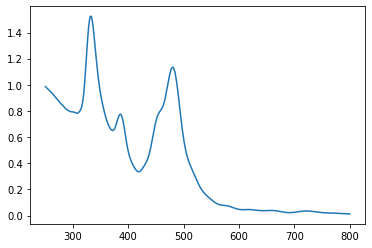

In [ ]:
x = Results4[2133]     #85
plt.plot(Wavelength,x)

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame(Results4[2133])

In [ ]:
#splitting the data to train and test for decoder network
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X_train4, X_test4, y_train4, y_test4 = train_test_split(Features4, Results4.T, random_state = 0, test_size = 0.2)
scaler = preprocessing.MinMaxScaler()

X_train4 = scaler.fit_transform(X_train4)
X_test4 = scaler.transform(X_test4)

Features_normalized4 = scaler.transform(Features4)
N, D = X_train4.shape

In [ ]:
X_train4.shape

(1940, 10)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from tensorflow_addons.metrics import HammingLoss
LeakyRelu = tf.keras.layers.LeakyReLU(alpha=0.2)
tanh = tf.keras.activations.tanh
relu = tf.keras.activations.relu


# Decoder Model
model4 = Sequential()
model4.add(Dense(1024, input_shape=(D,), activation=relu))
model4.add(Dense(1024, activation=relu))
#model4.add(Dense(64, activation=relu))
#model4.add(Dense(64, activation=LeakyRelu))

model4.add(Dense(200, activation='linear'))

In [ ]:
tf.keras.backend.clear_session()     
model4.compile(loss='mae', optimizer=Adam(lr=0.001), metrics=['accuracy']) #metrics=['accuracy']  loss='binary_crossentropy'  #metrics=['binary_accuracy'] metrics=[HammingLoss(threshold=0.5, mode='multilabel')]                                                                                      
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto',baseline=None, restore_best_weights=False)
history4 = model4.fit(X_train4, y_train4, validation_split=0.2,batch_size=32, epochs=1500,callbacks=callback)

Epoch 1/1500
49/49 [==============================] - 1s 22ms/step - loss: 0.2288 - accuracy: 0.0457 - val_loss: 0.1259 - val_accuracy: 0.0979
Epoch 2/1500
49/49 [==============================] - 1s 18ms/step - loss: 0.0984 - accuracy: 0.1005 - val_loss: 0.0862 - val_accuracy: 0.1031
Epoch 3/1500
49/49 [==============================] - 1s 18ms/step - loss: 0.0779 - accuracy: 0.1366 - val_loss: 0.0782 - val_accuracy: 0.0799
Epoch 4/1500
49/49 [==============================] - 1s 18ms/step - loss: 0.0693 - accuracy: 0.1643 - val_loss: 0.0693 - val_accuracy: 0.1753
Epoch 5/1500
49/49 [==============================] - 1s 18ms/step - loss: 0.0643 - accuracy: 0.1753 - val_loss: 0.0648 - val_accuracy: 0.1340
Epoch 6/1500
49/49 [==============================] - 1s 18ms/step - loss: 0.0596 - accuracy: 0.2030 - val_loss: 0.0694 - val_accuracy: 0.1314
Epoch 7/1500
49/49 [==============================] - 1s 18ms/step - loss: 0.0591 - accuracy: 0.2010 - val_loss: 0.0587 - val_accuracy: 0.2062

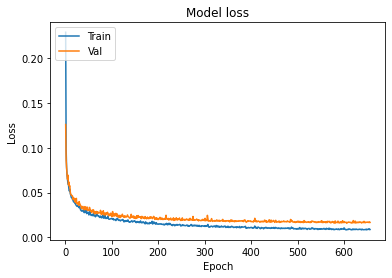

In [ ]:
def plot_learningCurve(history, epoch):
  epoch_range = range(1, epoch+1)
  # Plot training & validation loss values
  plt.plot(epoch_range, history4.history['loss'])
  plt.plot(epoch_range, history4.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

plot_learningCurve(history4, len(history4.history['loss']))

In [ ]:
pd.set_option('display.max_rows', None)
pd.DataFrame(history4.history['val_loss'])

In [ ]:
#saving the model
#model4.save('Decoder.h5')

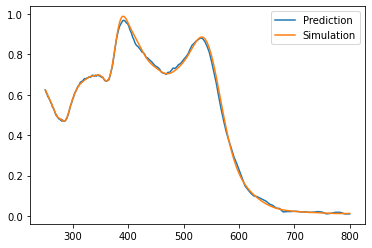

In [ ]:
i=420
F = Features_normalized4[i].reshape((1,10))

Yhat = model4.predict(F)
plt.plot(Wavelength,Yhat.T)
plt.plot(Wavelength,Results4[i])
plt.legend(['Prediction', 'Simulation'])

In [ ]:
#Loading the images 
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
import cv2

sample = []

for i in tqdm(range(2426)):
  path = images_dir +'/'+ str(i+1) + '.jpg'
  img = image.load_img(path)
  img = image.img_to_array(img)
  img = img/255.0
  img = cv2.resize(img, (108, 72), interpolation = cv2.INTER_AREA) 
  sample.append(img)
sample = np.array(sample)

100%|██████████| 2426/2426 [15:06<00:00,  2.68it/s]


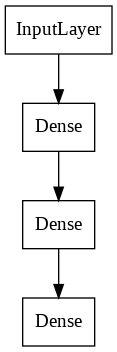

In [ ]:
#loading the saved models and visualizing it
Regressor_classifier =  tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Vision_classifier_regressor_small.h5')
Decoder = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Vision/Final_Models/Decoder.h5')
tf.keras.utils.plot_model(Decoder, show_shapes=False,show_layer_names=False, rankdir='TB')

In [ ]:
def label_maker (L):
  L[L >= 0.5] = 1
  L[L < 0.5] = 0
  return L

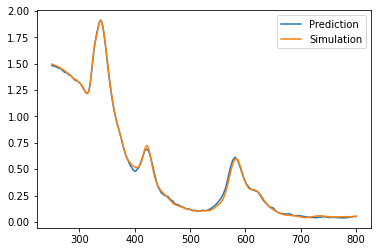

In [ ]:
# 50 120 250 300 387 420 500 600 700 803 920 1096 1100 1200 1380 1410 1550 1600 1700 1800 1960 2050 2100 2145 2200 2327 2410
i=2100 # 50 120 250 300 387 500 600 700 1096 1410 2050 2100
p=np.hstack((label_maker(Regressor_classifier.predict(sample[i].reshape(1,72,108,3))[0]), Regressor_classifier.predict(sample[i].reshape(1,72,108,3))[1]))
P1 = scaler.transform(p)

Yhat = Decoder.predict(P1)
plt.plot(Wavelength,Yhat.T)
plt.plot(Wavelength,Results4[i])
plt.legend(['Prediction', 'Simulation'])

In [ ]:
pd.set_option('display.max_rows', None)
x=pd.DataFrame(Yhat.T)  #Yhat.T    Results4[i]
#x=pd.DataFrame(Results4[i])
print(x.to_string(index=False))

        0
 0.063932
 0.079405
 0.086655
 0.096998
 0.111441
 0.130269
 0.164639
 0.217066
 0.280672
 0.347338
 0.409853
 0.463839
 0.507970
 0.530285
 0.531709
 0.516511
 0.495822
 0.461479
 0.420971
 0.387693
 0.362541
 0.358908
 0.351999
 0.361670
 0.380814
 0.402085
 0.430672
 0.456734
 0.478855
 0.495569
 0.500789
 0.502488
 0.501989
 0.500163
 0.496115
 0.486623
 0.480249
 0.473010
 0.467686
 0.463851
 0.458425
 0.452636
 0.445479
 0.440152
 0.437537
 0.435827
 0.438223
 0.439887
 0.441235
 0.440953
 0.444235
 0.443055
 0.442999
 0.442494
 0.442976
 0.443747
 0.447660
 0.447924
 0.452422
 0.451874
 0.457612
 0.459350
 0.462191
 0.465942
 0.472005
 0.474202
 0.479567
 0.483513
 0.485568
 0.486313
 0.491898
 0.490288
 0.496750
 0.496223
 0.498826
 0.499183
 0.502332
 0.503724
 0.504239
 0.506277
 0.507737
 0.508724
 0.511164
 0.510658
 0.509368
 0.512816
 0.513486
 0.511760
 0.513000
 0.512158
 0.512960
 0.511715
 0.512505
 0.511641
 0.509279
 0.509021
 0.512158
 0.510515
 0.509270
